In [65]:
from PIL import Image
from PIL import ImageGrab
from PIL import Image

def stack_images(img1: Image.Image, img2: Image.Image, direction: str = "horizontal") -> Image.Image:
    """
    Stack two PIL images either horizontally or vertically.
    Both images are resized to the smaller image's size before stacking.

    Parameters:
        img1 (PIL.Image.Image): First image
        img2 (PIL.Image.Image): Second image
        direction (str): "horizontal" or "vertical"

    Returns:
        PIL.Image.Image: The stacked image
    """
    # Get dimensions
    w1, h1 = img1.size
    w2, h2 = img2.size

    # Resize both to the smaller dimensions
    new_w, new_h = max(w1, w2), max(h1, h2)
    img1_resized = img1.resize((new_w, new_h), Image.LANCZOS)
    img2_resized = img2.resize((new_w, new_h), Image.LANCZOS)

    if direction == "horizontal":
        # Side by side
        new_img = Image.new("RGB", (new_w * 2, new_h))
        new_img.paste(img1_resized, (0, 0))
        new_img.paste(img2_resized, (new_w, 0))
    elif direction == "vertical":
        # Top and bottom
        new_img = Image.new("RGB", (new_w, new_h * 2))
        new_img.paste(img1_resized, (0, 0))
        new_img.paste(img2_resized, (0, new_h))
    else:
        raise ValueError("direction must be 'horizontal' or 'vertical'")

    return new_img


In [1]:
import torch
import matplotlib.pyplot as plt
import numpy as np
from transformers import ViTForImageClassification, ViTImageProcessor
from PIL import Image
import requests
from PIL import ImageGrab
CACHE_DIR = "G:/MLCache"
model_name = "facebook/dino-vitb8"
import io
import matplotlib

# Load model with attentions enabled
try:
    model
except NameError:
    print("Not declared")
    model = ViTForImageClassification.from_pretrained(model_name, output_attentions=True, cache_dir=CACHE_DIR)
    processor = ViTImageProcessor.from_pretrained(model_name)
    pass

Not declared


Some weights of ViTForImageClassification were not initialized from the model checkpoint at facebook/dino-vitb8 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [2]:
# Forward pass with attention outputs
def getAttentionMap(image):
    inputs = processor(images=image, return_tensors="pt")
    model.eval()
    with torch.no_grad():
        outputs = model(**inputs, output_attentions=True)

    # Extract attention weights (last layer, average across heads)
    attentions = outputs.attentions[-1]  # Shape: [batch_size, num_heads, seq_len, seq_len]
    attentions = attentions.mean(dim=1)  # Average across heads: [batch_size, seq_len, seq_len]

    # Get attention scores for the class token (index 0)
    cls_attention = attentions[0, 0, 1:]  # Exclude class token self-attention
    num_patches = int(np.sqrt(cls_attention.shape[0]))  # e.g., 14 for 14x14 grid
    attention_map = cls_attention.reshape(num_patches, num_patches).cpu().numpy()

    # Upscale attention map to image size
    from scipy.ndimage import zoom
    attention_map = zoom(attention_map, zoom=(image.size[1] / num_patches, image.size[0] / num_patches))

    # Visualize original image and attention heatmap
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(image)
    plt.title("Original Image")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(image, alpha=0.5)
    plt.imshow(attention_map, cmap="hot", alpha=0.5)
    plt.title("Attention Heatmap")
    plt.axis("off")
    plt.show()

In [3]:
def get_attention_map(image, show_image = True):
    inputs = processor(images=image, return_tensors="pt")

    # Forward pass
    with torch.no_grad():
        outputs = model(**inputs)
        logits = outputs.logits

    pred_id = logits.argmax(-1).item()
    print("Predicted class:", model.config.id2label[pred_id])
    if(show_image):
        # Extract attentions: tuple of (layers, batch, heads, tokens, tokens)
        attentions = outputs.attentions

        # Take last layer, average over heads
        attn = attentions[-1][0].mean(0)  # shape: (tokens, tokens)

        # CLS token attends to image patches
        cls_attn = attn[0, 1:]  # exclude the CLS token itself
        grid_size = int(cls_attn.shape[0] ** 0.5)  # e.g. 14x14 for 224/16
        attn_map = cls_attn.reshape(grid_size, grid_size).numpy()

        # Normalize
        attn_map = (attn_map - attn_map.min()) / (attn_map.max() - attn_map.min())

        # Plot overlay
        plt.imshow(image.resize((224, 224)))
        plt.imshow(attn_map, cmap="jet", alpha=0.5, extent=(0,224,224,0))
        plt.axis("off")
        plt.show()

In [26]:
def getAttentionMaps(image):
    inputs = processor(images=image, return_tensors="pt")

# Forward pass with attention outputs
    model.eval()
    with torch.no_grad():
        outputs = model(**inputs, output_attentions=True)

    # Extract attention weights from the last layer
    attentions = outputs.attentions[-1]  # Shape: [batch_size, num_heads, seq_len, seq_len]
    num_heads = attentions.shape[1]  # e.g., 12 for ViT-Base
    num_patches = int(np.sqrt(attentions.shape[-1] - 1))  # e.g., 14 for 14x14 grid

    # Visualize attention for each head
    fig, axes = plt.subplots(3, 4, figsize=(15, 10))  # Adjust for number of heads (e.g., 12)
    axes = axes.flatten()

    for head_idx in range(num_heads):
        # Get attention scores for the class token (index 0) for this head
        cls_attention = attentions[0, head_idx, 0, 1:]  # Exclude class token self-attention
        attention_map = cls_attention.reshape(num_patches, num_patches).cpu().numpy()

        # Upscale attention map to image size
        from scipy.ndimage import zoom
        attention_map = zoom(attention_map, zoom=(image.size[1] / num_patches, image.size[0] / num_patches))

        # Plot heatmap for this head
        axes[head_idx].imshow(image, alpha=0.5)
        axes[head_idx].imshow(attention_map, cmap="hot", alpha=0.5)
        axes[head_idx].set_title(f"Head {head_idx + 1}")
        axes[head_idx].axis("off")

    plt.tight_layout()
    plt.show()
url = "https://picsum.photos/200"
image = Image.open(requests.get(url, stream=True).raw).convert("RGB")

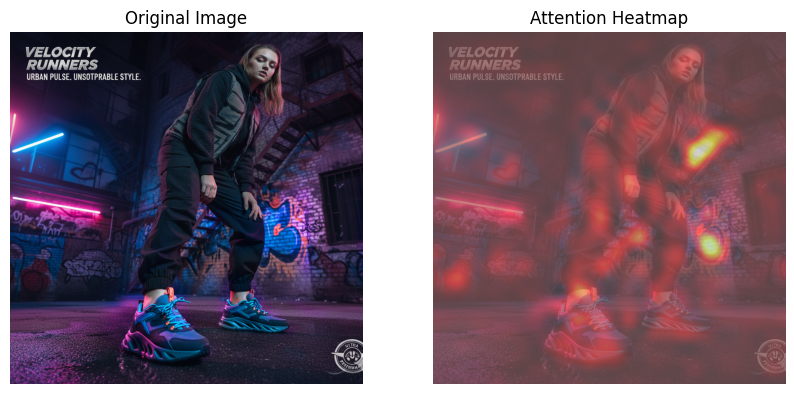

In [79]:
imageA = ImageGrab.grabclipboard()
getAttentionMap(imageA)

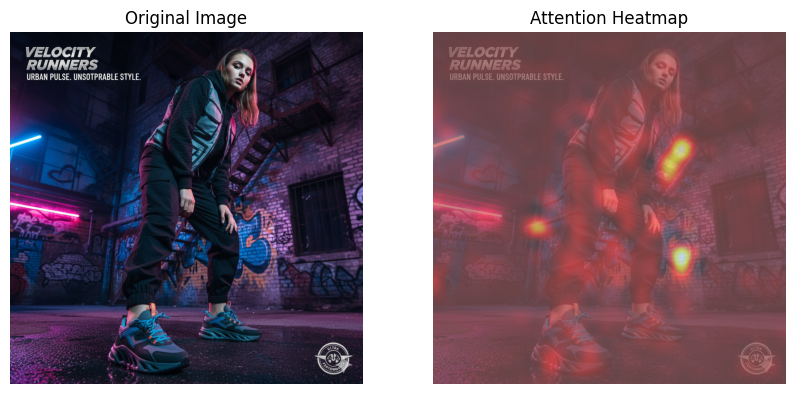

In [69]:
imageB = ImageGrab.grabclipboard()
getAttentionMap(imageB)

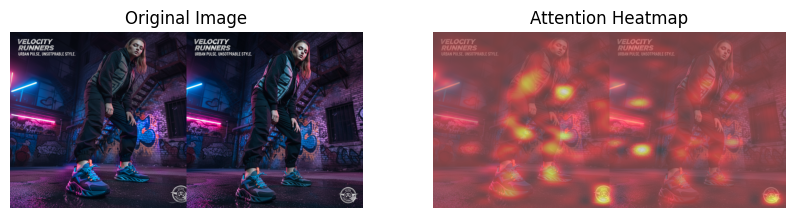

In [80]:
getAttentionMap(stack_images(imageA, imageB, direction="horizontal"))

Predicted class: LABEL_1


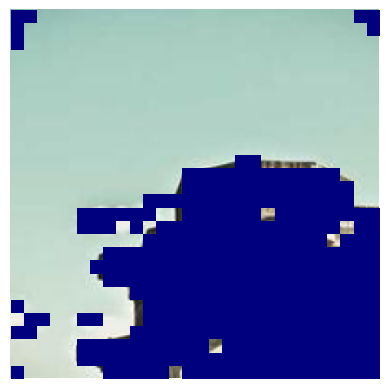

<Figure size 1000x1000 with 0 Axes>

In [21]:
def get_masked_attention_map(image):
    inputs = processor(images=image, return_tensors="pt")

    # Forward pass
    with torch.no_grad():
        outputs = model(**inputs)
        logits = outputs.logits

    pred_id = logits.argmax(-1).item()
    print("Predicted class:", model.config.id2label[pred_id])

    # Extract attentions: tuple of (layers, batch, heads, tokens, tokens)
    attentions = outputs.attentions

    # Take last layer, average over heads
    attn = attentions[-1][0].mean(0)  # shape: (tokens, tokens)

    # CLS token attends to image patches
    cls_attn = attn[0, 1:]  # exclude the CLS token itself
    grid_size = int(cls_attn.shape[0] ** 0.5)  # e.g. 14x14 for 224/16
    attn_map = cls_attn.reshape(grid_size, grid_size).numpy()

    # Normalize
    attn_map = (attn_map - attn_map.min()) / (attn_map.max() - attn_map.min())
    attn_map = np.where(attn_map > 0.05, 1, 0)

    # Plot overlay
    cmap = matplotlib.colormaps["jet"].copy()
    masked = np.ma.masked_equal(attn_map, 0)
    # cmap.set_bad(color='red', alpha=0)
    # cmap.set_bad(color='blue', alpha=0)

    fig, ax = plt.subplots()
    plt.imshow(image.resize((224, 224)))
    plt.imshow(masked, cmap=cmap, extent=(0,224,224,0))
    plt.margins(0,0)
    # plt.imshow(attn_map, cmap="jet", extent=(0,224,224,0), alpha=attn_map)
    plt.axis("off")
    plt.show()
    plt.figure(figsize=(10, 10))
    # get_attention_map(img, show_image=False)

get_masked_attention_map(image)

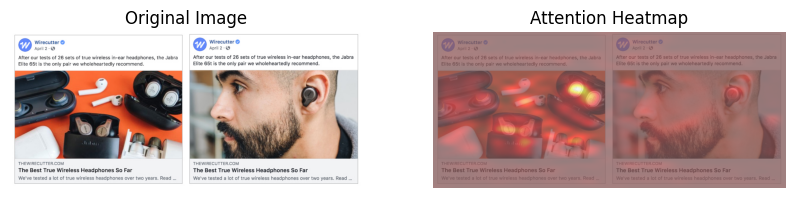

In [36]:
getAttentionMap(ImageGrab.grabclipboard())

Predicted class: LABEL_1


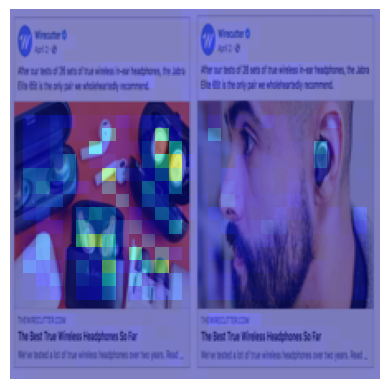

In [37]:
get_attention_map(ImageGrab.grabclipboard())

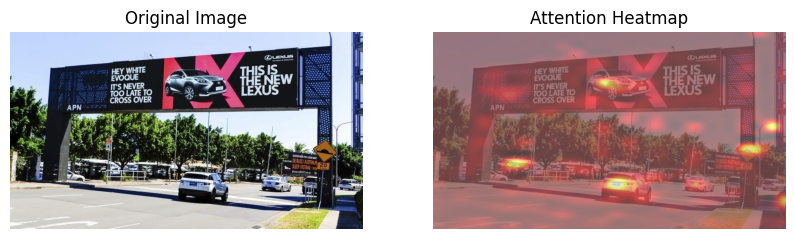

In [17]:
getAttentionMap(ImageGrab.grabclipboard())

Predicted class: LABEL_1


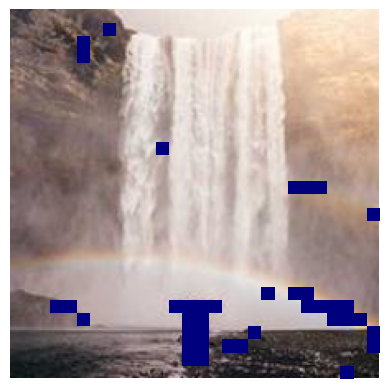

<Figure size 1000x1000 with 0 Axes>

In [10]:
get_masked_attention_map(image)

Predicted class: LABEL_1


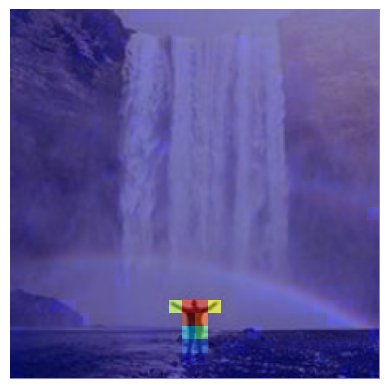

In [11]:
get_attention_map(image)

In [12]:
get_multi_attention_maps(image)

NameError: name 'image' is not defined

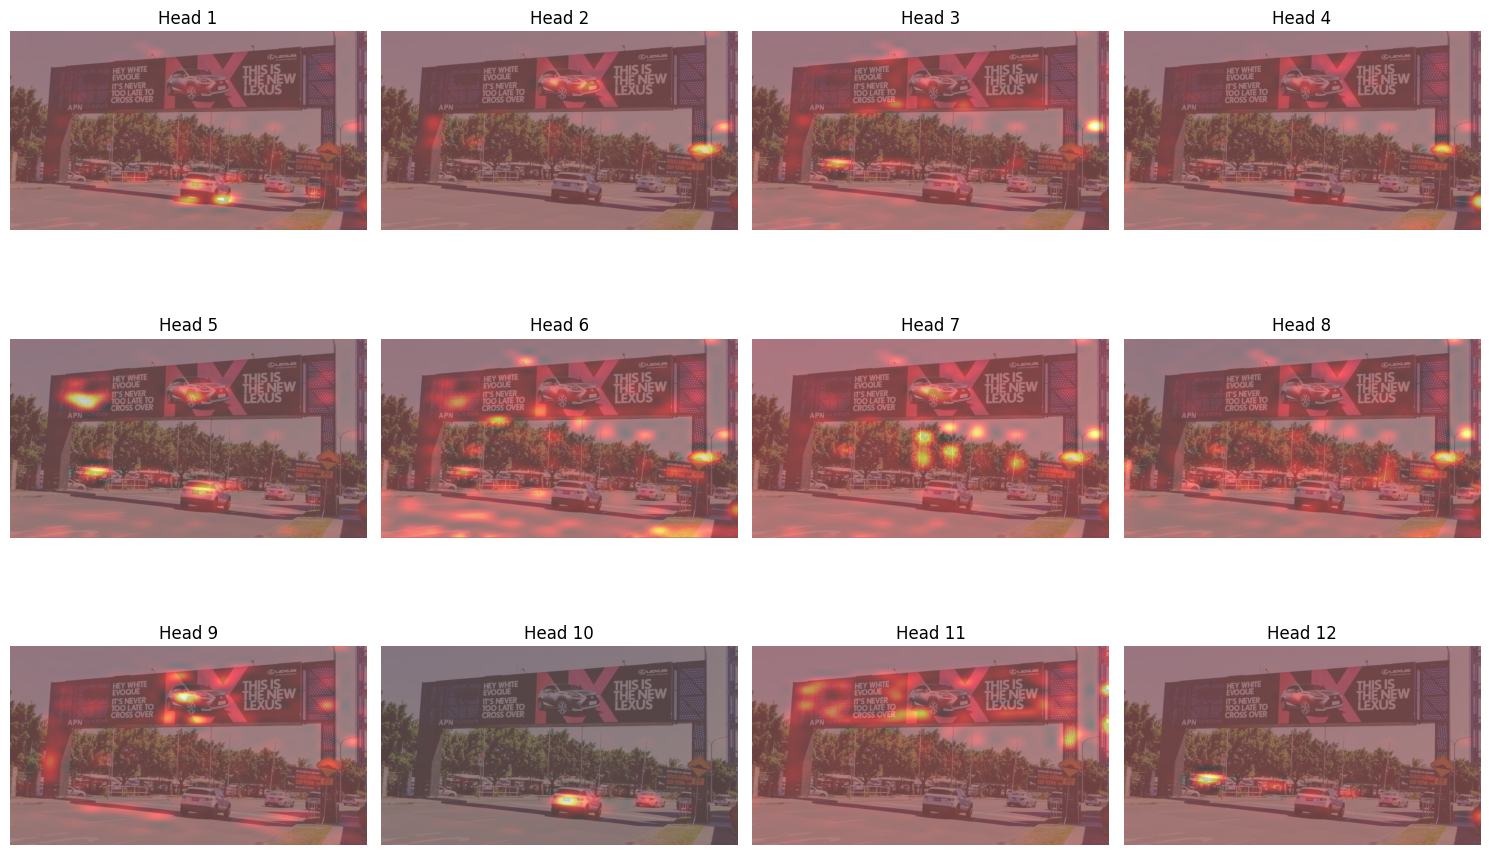

In [16]:
get_multi_attention_maps(ImageGrab.grabclipboard())

Predicted class: wild boar, boar, Sus scrofa


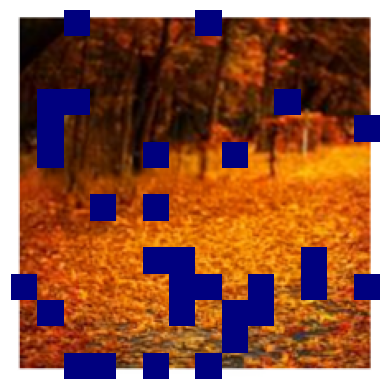

In [97]:
get_masked_attention_map(ImageGrab.grabclipboard())